<a href="https://colab.research.google.com/github/yohanes-erwin/notebook/blob/main/lstm_stock_sentiment_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/Colab Notebooks

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


### Data Preprocessing

Load data dari file .csv.

In [3]:
stock_df = pd.read_csv('stock_sentiment.csv')
stock_df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [4]:
print(stock_df.isnull().sum())

Text         0
Sentiment    0
dtype: int64


In [5]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


Menghilangkan punctuation dari text.

In [6]:
# Function to remove punctuations
def remove_punc(message):
  punc_removed = [char for char in message if char not in string.punctuation]
  punc_removed_join = ''.join(punc_removed)
  return punc_removed_join

In [7]:
stock_df['Text Without Punctuation'] = stock_df['Text'].apply(remove_punc)
stock_df

,Text,Sentiment,Text Without Punctuation
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...
3,MNTA Over 12.00,1,MNTA Over 1200
4,OI Over 21.37,1,OI Over 2137
...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...


In [8]:
stock_df['Text'][0]

'Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2, see prev posts'

In [9]:
stock_df['Text Without Punctuation'][0]

'Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2 see prev posts'

Menghilangkan stopwords dari text.

In [10]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
stop_words = stopwords.words('english')
stop_words.extend(['from','subject','re','edu','use','will','aap','co','day','user','stock','today','week','year'])

In [12]:
# Function to remove stopwords and short words (less than 2 characters)
def preprocess(text):
  result = []
  for token in gensim.utils.simple_preprocess(text):
    if len(token) >= 3 and token not in stop_words:
      result.append(token)
  return result

In [13]:
stock_df['Text Without Punctuation & Stopwords'] = stock_df['Text Without Punctuation'].apply(preprocess)
stock_df

,Text,Sentiment,Text Without Punctuation,Text Without Punctuation & Stopwords
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,..."
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw..."
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[afraid, short, amzn, looking, like, nearmonop..."
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta]
4,OI Over 21.37,1,OI Over 2137,[]
...,...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...,"[industry, body, cii, said, discoms, likely, s..."
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...,"[gold, prices, slip, investors, book, profits,..."
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...,"[workers, bajaj, auto, agreed, wage, cut, peri..."
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...,"[sharemarket, live, sensex, high, points, nift..."


In [14]:
stock_df['Text Without Punctuation'][0]

'Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2 see prev posts'

In [15]:
stock_df['Text Without Punctuation & Stopwords'][0]

['kickers',
 'watchlist',
 'xide',
 'tit',
 'soq',
 'pnk',
 'cpw',
 'bpz',
 'trade',
 'method',
 'method',
 'see',
 'prev',
 'posts']

Melakukan plot untuk visualisasi data.

In [16]:
stock_df['Text Without Punctuation & Stopwords Joined'] = stock_df['Text Without Punctuation & Stopwords'].apply(lambda x : " ".join(x))
stock_df

,Text,Sentiment,Text Without Punctuation,Text Without Punctuation & Stopwords,Text Without Punctuation & Stopwords Joined
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,...",kickers watchlist xide tit soq pnk cpw bpz tra...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw...",movie return feageed indicator trades awesome
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[afraid, short, amzn, looking, like, nearmonop...",afraid short amzn looking like nearmonopoly eb...
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta],mnta
4,OI Over 21.37,1,OI Over 2137,[],
...,...,...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...,"[industry, body, cii, said, discoms, likely, s...",industry body cii said discoms likely suffer n...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...,"[gold, prices, slip, investors, book, profits,...",gold prices slip investors book profits amid c...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...,"[workers, bajaj, auto, agreed, wage, cut, peri...",workers bajaj auto agreed wage cut period apri...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...,"[sharemarket, live, sensex, high, points, nift...",sharemarket live sensex high points nifty test...


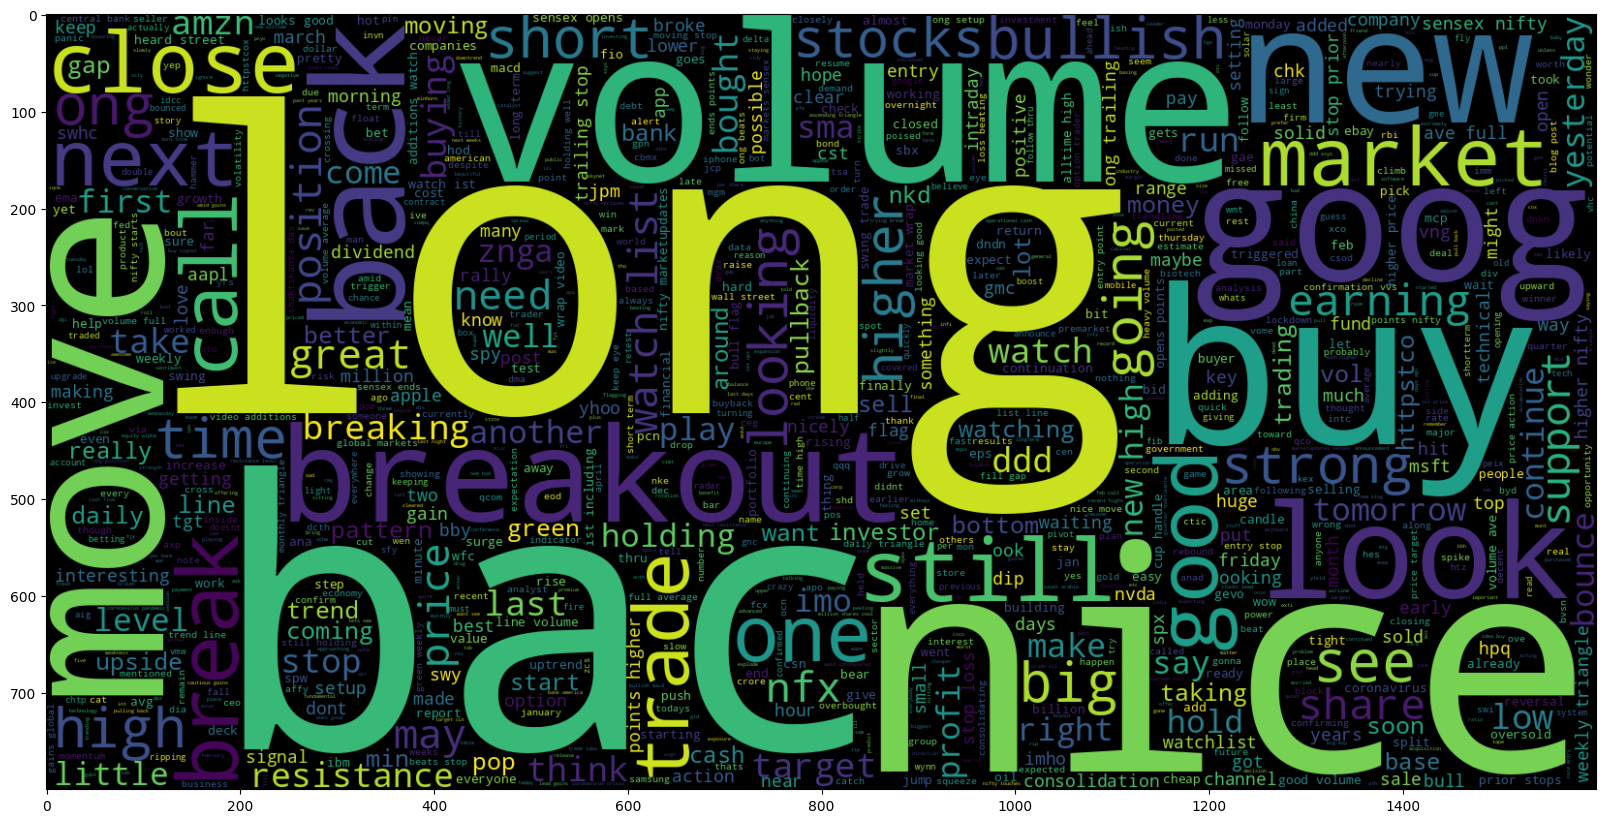

In [17]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(" ".join(stock_df[stock_df['Sentiment']==1]['Text Without Punctuation & Stopwords Joined']))
plt.imshow(wc, interpolation='bilinear')

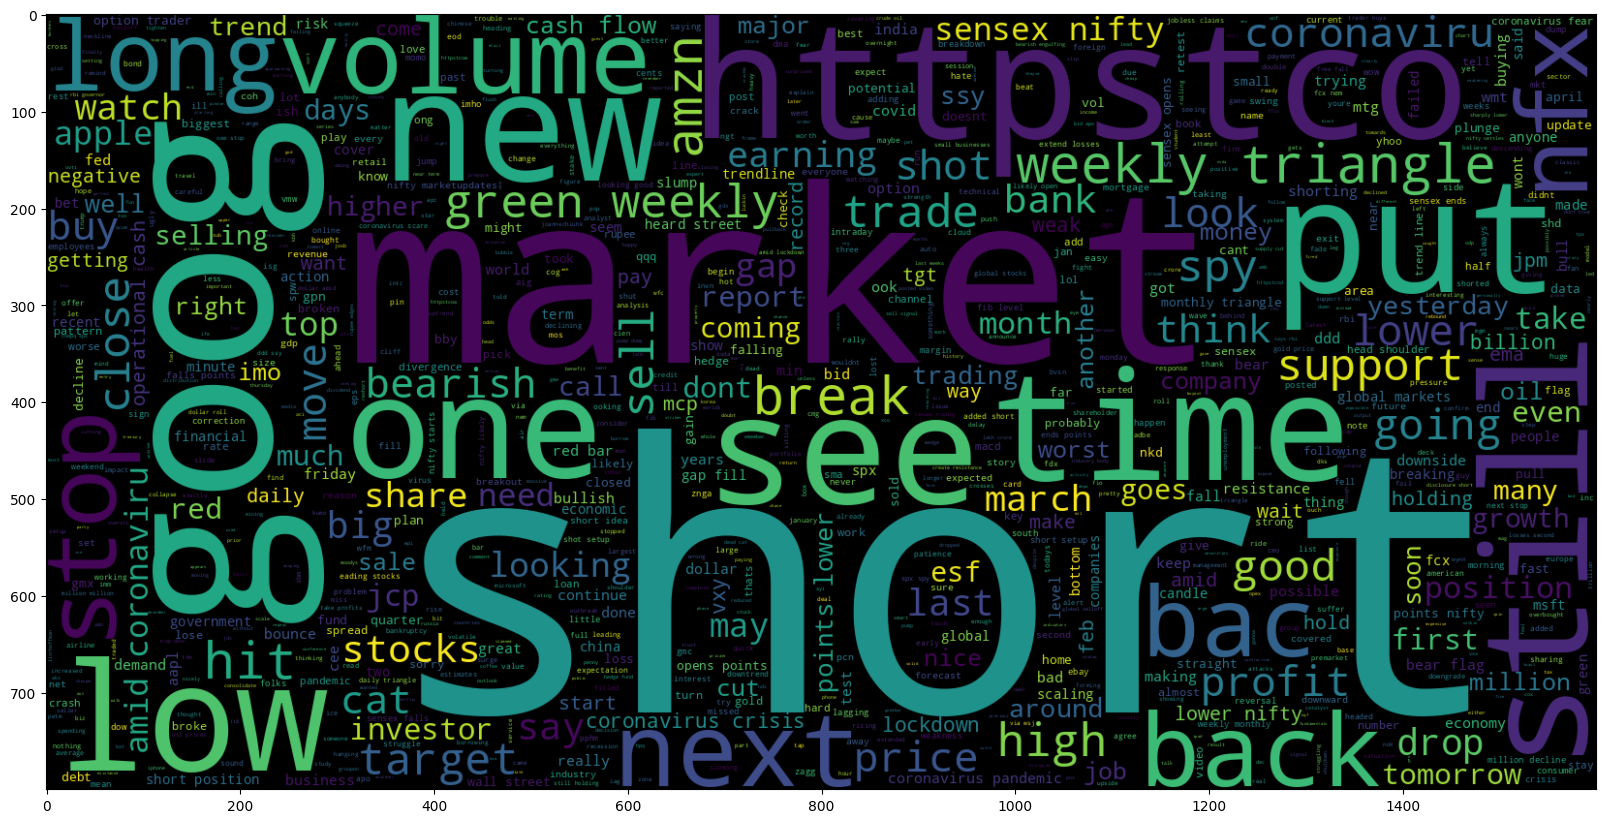

In [18]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(" ".join(stock_df[stock_df['Sentiment']==0]['Text Without Punctuation & Stopwords Joined']))
plt.imshow(wc, interpolation='bilinear')

In [19]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:
# Word_tokenize is used to break up a string into words
print(stock_df['Text Without Punctuation & Stopwords Joined'][0])
print(nltk.word_tokenize(stock_df['Text Without Punctuation & Stopwords Joined'][0]))

kickers watchlist xide tit soq pnk cpw bpz trade method method see prev posts
['kickers', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'trade', 'method', 'method', 'see', 'prev', 'posts']


In [21]:
print(stock_df['Text Without Punctuation & Stopwords'][0])

['kickers', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'trade', 'method', 'method', 'see', 'prev', 'posts']


In [22]:
maxlen = -1
for doc in stock_df['Text Without Punctuation & Stopwords Joined']:
  tokens = nltk.word_tokenize(doc)
  if (maxlen < len(tokens)):
    maxlen = len(tokens)
print("The maximum number of words in any document is:", maxlen)

The maximum number of words in any document is: 20


In [23]:
tweets_length = [len(nltk.word_tokenize(x)) for x in stock_df['Text Without Punctuation & Stopwords Joined']]
tweets_length[0:5]

[14, 6, 7, 1, 0]

In [24]:
# Plot the distribution for the number of words in a text
fig = px.histogram(x=tweets_length, nbins=50)
fig.show()

Melakukan splitting data train dan test.

In [25]:
# Obtain the total words present in the dataset
list_of_words = []
for i in stock_df['Text Without Punctuation & Stopwords']:
  for j in i:
    list_of_words.append(j)
len(list_of_words)

45099

In [26]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

9268

In [27]:
X = stock_df['Text Without Punctuation & Stopwords']
y = stock_df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [28]:
X_train.shape

(5211,)

In [29]:
X_train[0]

['kickers',
 'watchlist',
 'xide',
 'tit',
 'soq',
 'pnk',
 'cpw',
 'bpz',
 'trade',
 'method',
 'method',
 'see',
 'prev',
 'posts']

Mengubah input dari data text menjadi angka.

In [30]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(X_train)

In [31]:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [32]:
train_sequences[0]

[10, 24, 1525, 595, 3608, 149, 2459, 1526]

Menambahkan padding agar semua input memiliki jumlah token yang sama.

In [33]:
# Add padding to training and testing
padded_train = pad_sequences(train_sequences, maxlen=29, padding='post', truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=29, truncating='post')

In [34]:
for i, doc in enumerate(padded_train[:3]):
  print("The padded encoding for document", i+1, "is:\n", doc)

The padded encoding for document 1 is:
 [  10   24 1525  595 3608  149 2459 1526    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
The padded encoding for document 2 is:
 [1131  861 1132   44  184   85  217  130  452 3609   18 3610    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
The padded encoding for document 3 is:
 [113 265   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]


Mengubah output menjadi data categorical.

In [35]:
# Convert the data to categorical 2D representation
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [36]:
y_train_cat.shape

(5211, 2)

In [37]:
y_train_cat

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

### LSTM Network

Membuat model LSTM.

In [38]:
model = Sequential()

In [39]:
model.add(Embedding(total_words, output_dim=512))
model.add(LSTM(256))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

In [40]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 512)         4745216   
                                                                 
 lstm (LSTM)                 (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 5565826 (21.23 MB)
Trainable params: 5565826 (21.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
model.fit(padded_train, y_train_cat, batch_size=32, validation_split=0.2, epochs=2)

Epoch 1/2
131/131 [==============================] - 47s 341ms/step - loss: 0.6620 - acc: 0.6286 - val_loss: 0.5418 - val_acc: 0.7354
Epoch 2/2
131/131 [==============================] - 42s 317ms/step - loss: 0.4724 - acc: 0.7958 - val_loss: 0.5464 - val_acc: 0.7402


### Inference

Melakukan prediksi.

In [43]:
pred = model.predict(padded_test)

19/19 [==============================] - 1s 51ms/step


In [44]:
pred

array([[0.43552905, 0.564471  ],
       [0.7196374 , 0.2803625 ],
       [0.3816998 , 0.6183002 ],
       ...,
       [0.64759356, 0.3524064 ],
       [0.47332576, 0.5266743 ],
       [0.44514722, 0.55485284]], dtype=float32)

In [45]:
prediction = []
for i in pred:
  prediction.append(np.argmax(i))

In [46]:
prediction[0:5]

[1, 0, 1, 0, 0]

In [47]:
# List containing original values
original = []
for i in y_test_cat:
  original.append(np.argmax(i))

In [48]:
original[0:5]

[1, 1, 1, 0, 0]

In [49]:
accuracy = accuracy_score(original, prediction)
accuracy

0.7758620689655172

<Axes: >

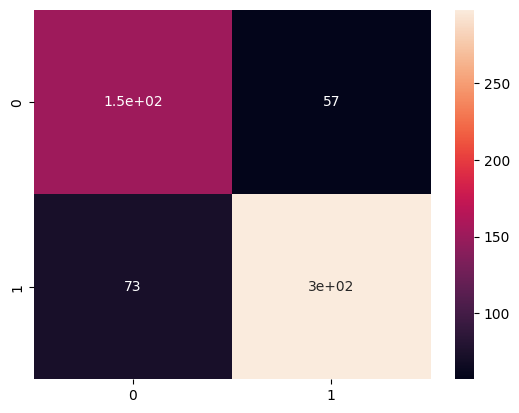

In [50]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True)